# Analysis of Medicare Part D Prescribing Trends for GLP-1 Agonists (2014-2023)

data source(for public use): <href>https://catalog.data.gov/dataset/medicare-part-d-prescribers-by-geography-and-drug-d1df1</href>

## 1. Introduction

### Background and Motivation

GLP-1 (Glucagon-like peptide-1) agonists represent a significant and rapidly evolving class of medications used primarily for the management of type 2 diabetes and, increasingly, for obesity. Their impact on clinical outcomes and healthcare spending has drawn considerable attention. Understanding the prescribing trends of these agents within large patient populations, such as Medicare beneficiaries, is crucial for healthcare providers, policymakers, and pharmaceutical market analysts. This project aims to analyze the utilization patterns and associated costs of GLP-1 agonists within the US Medicare Part D program using publicly available data. As a pharmacist, I bring domain expertise to interpret these trends within a clinical and market context.

### Data Source

The primary data source for this analysis is the publicly available **Medicare Part D Prescribers - by Geography and Drug** dataset provided by the Centers for Medicare & Medicaid Services (CMS), covering the years 2014 through 2023. (*Note: Data for 2024 was not available at the time of analysis in April 2025.*)

### Key Questions

This analysis seeks to answer the following questions regarding GLP-1 agonist prescribing trends in Medicare Part D:

1.  How have the overall number of beneficiaries using GLP-1 agonists and the total drug costs changed from 2014 to 2023?
2.  Which specific GLP-1 agonists (generic and brand names) have shown the most significant growth in utilization during this period?
3.  How do prescribing trends vary geographically? (This analysis includes a focused case study on Georgia.)
4.  Is there an observable relationship between the dosage frequency (e.g., once-daily vs. once-weekly) of GLP-1 agonists and their utilization trends or market share?
5.  How have the market shares and average costs per beneficiary for different GLP-1 agonists evolved over time, particularly within the Georgia context?

## 2. Data Loading and Preparation
### 2.1. Import Libraries

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import seaborn as sns
import glob
import os

### 2.2. Load Data (2014 - 2023)

In [ ]:
# Import Medicare Part D Prescribers - by Geography and Drug csv files for last 10 years
# path = 'Raw Data CSV/'
# all_files = sorted(glob.glob(os.path.join(path, "*.csv")), reverse=True)

# # Columns to keep for analysis
# columns_to_keep = [
#     'Prscrbr_Geo_Desc',
#     'Brnd_Name',
#     'Gnrc_Name',
#     'Tot_Prscrbrs',
#     'Tot_Clms',
#     'Tot_Drug_Cst',
#     'Tot_Benes'
# ]

# dfs = []
# for filename in all_files:
#     df = pd.read_csv(filename, low_memory=False)
#     df = df[columns_to_keep]
#     dfs.append(df)

# years = range(2023, 2013, -1) # 2023 to 2014
# df_list = []

# for year in years:
#     # use f-strings to construct file path
#     dy_code = str(year - 2000) # 2023 -> 23
#     file_path = f'Raw Data CSV/MUP_DPR_RY{int(dy_code)+2}_P04_V10_DY{dy_code}_Geo.csv' 
        
#     if os.path.exists(file_path):
#         temp_df = pd.read_csv(file_path, low_memory=False)
#         temp_df = temp_df[columns_to_keep]
#         temp_df['Year'] = year
#         df_list.append(temp_df)

# df10yrs = pd.concat(df_list, ignore_index=True)

##

import re  # Import regular expression module for year extraction

# 1. Set file path and retrieve a list of all CSV files
path = 'Raw Data CSV/'
all_files = sorted(glob.glob(os.path.join(path, "*.csv")), reverse=True)

# 2. Define columns to keep for analysis (to optimize memory usage)
columns_to_keep = [
    'Prscrbr_Geo_Desc',
    'Brnd_Name',
    'Gnrc_Name',
    'Tot_Prscrbrs',
    'Tot_Clms',
    'Tot_Drug_Cst',
    'Tot_Benes'
]

df_list = []

print(f"Found {len(all_files)} files. Starting data load...")

for filename in all_files:
    # 3. Extract the year from the filename using Regex
    # Looks for the pattern 'DY' followed by 2 digits (e.g., ...DY14... -> 14)
    match = re.search(r'DY(\d{2})', filename)
    
    if match:
        # Convert 2-digit year to 4-digit year (e.g., 23 -> 2023)
        year = 2000 + int(match.group(1))
        
        # Read CSV file
        temp_df = pd.read_csv(filename, low_memory=False)
        
        # Filter columns immediately to save memory
        temp_df = temp_df[columns_to_keep]
        
        # Add a 'Year' column
        temp_df['Year'] = year
        
        # Append to the list
        df_list.append(temp_df)
        print(f"Loaded Year: {year} | Rows: {len(temp_df)}")
    else:
        print(f"Skipping file (No year pattern found): {filename}")

# 4. Concatenate all dataframes into a single dataframe
df10yrs = pd.concat(df_list, ignore_index=True)

# 5. Verify the result
print("\nTotal Loaded Rows:", len(df10yrs))
df10yrs.info()

# Check descriptive statistics to ensure Year min is 2014 and max is 2023
print(df10yrs.describe())

### 2.3. Data Cleaning (Column Selection, Merging)
There are 22 columns, but the data I'm interested to analyze are brand and generic drug name of **GLP-1 agonists** and associated total prescribers, total claims, total drug cost, and total beneficieries. Therefore, I only need to take the following columns:
- Prscrbr_Geo_Desc
- Brnd_Name
- Gnrc_Name
- Tot_Prscrbrs
- Tot_Clms
- Tot_Drug_Cst
- Tot_Benes

Since a generic name of drug can have multiple brand names depending on their FDA indication and dosage forms, it would be better to filter the data with generic names of GLP-1 agonists that are currently available in the US market.

In [33]:
# Generic names of GLP-1 Agonists currently marketed in US
glp1_agonists_generic_names = [
    'exenatide',
    'semaglutide',
    'dulaglutide',
    'liraglutide',
    'lixisenatide',
    'tirzepatide'    
]

In [34]:
df10yrs.info()
df10yrs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576278 entries, 0 to 576277
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Prscrbr_Geo_Desc  576250 non-null  object 
 1   Brnd_Name         576278 non-null  object 
 2   Gnrc_Name         576278 non-null  object 
 3   Tot_Prscrbrs      576278 non-null  int64  
 4   Tot_Clms          576278 non-null  int64  
 5   Tot_Drug_Cst      576278 non-null  float64
 6   Tot_Benes         468035 non-null  float64
 7   Year              576278 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 35.2+ MB


,Tot_Prscrbrs,Tot_Clms,Tot_Drug_Cst,Tot_Benes,Year
count,576278.000000,5.762780e+05,5.762780e+05,4.680350e+05,576278.000000
mean,1559.749447,2.658789e+04,3.861303e+06,9.447323e+03,2021.004456
std,14136.043319,4.444960e+05,6.547084e+07,1.290575e+05,1.414560
min,1.000000,1.100000e+01,0.000000e+00,1.100000e+01,2019.000000
25%,13.000000,5.000000e+01,1.580524e+04,3.700000e+01,2020.000000
50%,60.000000,2.750000e+02,1.130923e+05,1.630000e+02,2021.000000
75%,412.000000,2.450000e+03,7.390704e+05,1.231000e+03,2022.000000
max,725303.000000,6.846728e+07,1.826613e+10,1.677038e+07,2023.000000


### 2.5. Handling Missing Values (`Tot_Benes`)
Now the combined dataframe has data for between 2014 and 2024 and the total row is 1126791, over 1.1 Million. As shown, many null values exist in Prscrbr_Geo_Desc and Tot_Benes columns.

In [35]:
# Check null values by column
df10yrs.isnull().sum()

Prscrbr_Geo_Desc        28
Brnd_Name                0
Gnrc_Name                0
Tot_Prscrbrs             0
Tot_Clms                 0
Tot_Drug_Cst             0
Tot_Benes           108243
Year                     0
dtype: int64

### 2.6. Filtering for GLP-1 Agonists

In [36]:
# Filter the dataframe with generic names of GLP-1 Agonists, then check any null values
glp1_df = df10yrs[df10yrs['Gnrc_Name'].str.lower().str.contains('|'.join(glp1_agonists_generic_names), na=False)].copy()
glp1_df.isnull().sum()
glp1_df.describe()

,Tot_Prscrbrs,Tot_Clms,Tot_Drug_Cst,Tot_Benes,Year
count,2821.000000,2.821000e+03,2.821000e+03,2.692000e+03,2821.000000
mean,2273.240340,3.267293e+04,4.248341e+07,7.249370e+03,2021.019142
std,11772.122081,2.341849e+05,3.106712e+08,4.780307e+04,1.411574
min,1.000000,1.100000e+01,7.136460e+03,1.100000e+01,2019.000000
25%,116.000000,5.880000e+02,6.890327e+05,1.907500e+02,2020.000000
50%,437.000000,3.001000e+03,3.498941e+06,8.440000e+02,2021.000000
75%,1390.000000,1.290100e+04,1.566327e+07,3.251750e+03,2022.000000
max,254476.000000,6.925667e+06,9.190972e+09,1.463887e+06,2023.000000


In [37]:
# Missing values in CMS data often imply suppression due to low counts (<11).
# Filling with 0 is statistically safer than mean imputation for this dataset.
glp1_df['Tot_Benes'] = glp1_df['Tot_Benes'].fillna(0)

In [38]:
glp1_df.info()
glp1_df.isnull().sum()
glp1_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2821 entries, 439 to 576265
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Prscrbr_Geo_Desc  2821 non-null   object 
 1   Brnd_Name         2821 non-null   object 
 2   Gnrc_Name         2821 non-null   object 
 3   Tot_Prscrbrs      2821 non-null   int64  
 4   Tot_Clms          2821 non-null   int64  
 5   Tot_Drug_Cst      2821 non-null   float64
 6   Tot_Benes         2821 non-null   float64
 7   Year              2821 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 198.4+ KB


,Prscrbr_Geo_Desc,Brnd_Name,Gnrc_Name,Tot_Prscrbrs,Tot_Clms,Tot_Drug_Cst,Tot_Benes,Year
439,National,Bydureon Bcise,Exenatide Microspheres,34075,212648,2.838735e+08,45828.0,2023
440,National,Bydureon Pen,Exenatide Microspheres,45,64,6.084105e+04,45.0,2023
441,National,Byetta,Exenatide,3739,14038,2.063854e+07,3394.0,2023
2051,National,Mounjaro,Tirzepatide,118860,1820883,2.360646e+09,370074.0,2023
2348,National,Ozempic,Semaglutide,254476,6925667,9.190972e+09,1463887.0,2023


In [39]:
# Filter glp1_df by Group By Geographic condition is Georgia state.
# Then, Group by Year, Gnrc_Name to aggregate Tot_Benes and Tot_Drug_Cst columns data
georgia_data = glp1_df[glp1_df['Prscrbr_Geo_Desc']=='Georgia'].copy()
georgia_agg_trends = georgia_data.groupby(['Year', 'Gnrc_Name'])[['Tot_Benes', 'Tot_Drug_Cst']].sum().reset_index()
georgia_agg_trends.head()

,Year,Gnrc_Name,Tot_Benes,Tot_Drug_Cst
0,2019,Dulaglutide,14186.0,80790313.75
1,2019,Exenatide,302.0,1728177.86
2,2019,Exenatide Microspheres,3729.0,15763553.52
3,2019,Insulin Degludec/Liraglutide,531.0,2309688.86
4,2019,Insulin Glargine/Lixisenatide,1126.0,3601630.26


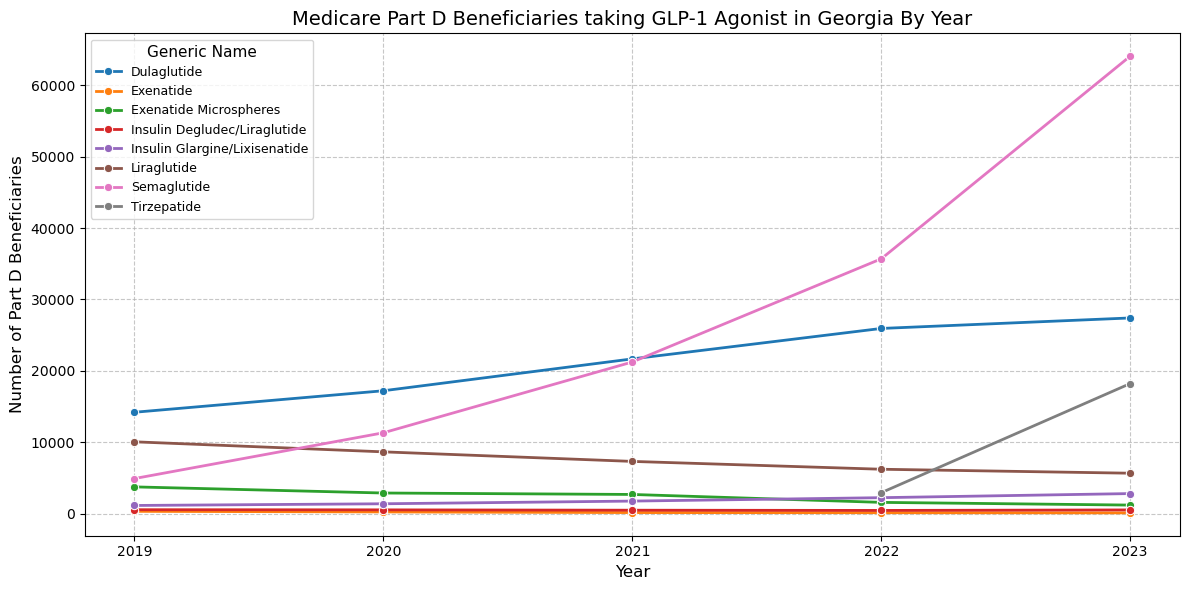


Medicare Part D Beneficiaries taking GLP-1 Agonist in Georgia By Year:
Gnrc_Name  Dulaglutide  Exenatide  Exenatide Microspheres  \
Year                                                        
2019           14186.0      302.0                  3729.0   
2020           17200.0      221.0                  2871.0   
2021           21666.0      130.0                  2669.0   
2022           25931.0      111.0                  1558.0   
2023           27402.0       86.0                  1180.0   

Gnrc_Name  Insulin Degludec/Liraglutide  Insulin Glargine/Lixisenatide  \
Year                                                                     
2019                              531.0                         1126.0   
2020                              510.0                         1363.0   
2021                              461.0                         1740.0   
2022                              430.0                         2217.0   
2023                              500.0                 

<Figure size 1200x600 with 0 Axes>

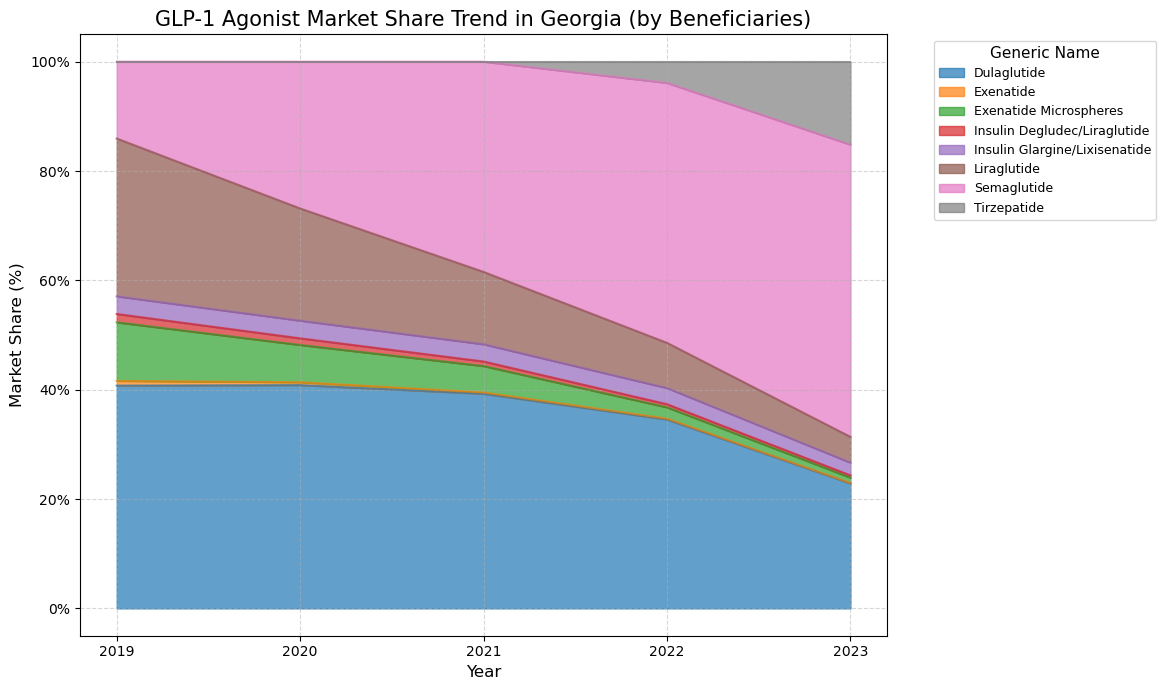

Gnrc_Name  Dulaglutide  Exenatide  Exenatide Microspheres  \
Year                                                        
2019         40.745634   0.867417               10.710593   
2020         40.840556   0.524754                6.817049   
2021         39.252844   0.235524                4.835495   
2022         34.549330   0.147892                2.075811   
2023         22.854426   0.071728                0.984170   

Gnrc_Name  Insulin Degludec/Liraglutide  Insulin Glargine/Lixisenatide  \
Year                                                                     
2019                           1.525161                       3.234145   
2020                           1.210970                       3.236377   
2021                           0.835205                       3.152402   
2022                           0.572913                       2.953834   
2023                           0.417021                       2.328646   

Gnrc_Name  Liraglutide  Semaglutide  Tirzepatide  
Ye

In [40]:
# Data Visualization

# Color mapping for each drug to display consistent data visualization
unique_drugs = sorted(georgia_agg_trends['Gnrc_Name'].unique())
palette = sns.color_palette('tab10', n_colors=len(unique_drugs))
color_map = dict(zip(unique_drugs, palette))

# Line plot: Medicare Part D beneficieries taking GLP-1 Agonist in Georgia By Year
plt.figure(figsize=(12, 6))
sns.lineplot(data=georgia_agg_trends, x='Year', y='Tot_Benes', hue='Gnrc_Name', marker='o', linewidth=2, palette=color_map)
plt.title('Medicare Part D Beneficiaries taking GLP-1 Agonist in Georgia By Year', fontsize=14)
plt.ylabel('Number of Part D Beneficiaries', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(georgia_agg_trends['Year'].unique())   # Ensure all years are shown as ticks
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Generic Name', title_fontsize=11, fontsize=9)
plt.tight_layout()
plt.show()

# Pivot Table
pivot_table_ga = georgia_agg_trends.pivot(index='Year', columns='Gnrc_Name', values='Tot_Benes')
print("\nMedicare Part D Beneficiaries taking GLP-1 Agonist in Georgia By Year:")
print(pivot_table_ga)

# GLP-1 Agonist Market Share Percentage By Year Calculation
georgia_agg_trends['Tot_Benes_Year'] = georgia_agg_trends.groupby('Year')['Tot_Benes'].transform('sum')
georgia_agg_trends['Market_Share_Percent'] = georgia_agg_trends['Tot_Benes'] / georgia_agg_trends['Tot_Benes_Year'] * 100

# Stacked Area Chart: Yearly Market Share Percentage Visualization 
plt.figure(figsize=(12, 6))
market_share_pivot = georgia_agg_trends.pivot(index='Year', columns='Gnrc_Name', values='Market_Share_Percent').fillna(0)
plot_colors = [color_map[drug] for drug in market_share_pivot.columns]  # Color mapping for each drug
market_share_pivot.plot(kind='area', stacked=True, figsize=(14, 7), alpha=0.7, color=plot_colors)

plt.title('GLP-1 Agonist Market Share Trend in Georgia (by Beneficiaries)', fontsize=15)
plt.ylabel('Market Share (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(georgia_agg_trends['Year'].unique())
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100)) # Y-axis display as percentage
plt.legend(title='Generic Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title_fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to fit legend
plt.show()

# Pivot Table
print(market_share_pivot)

In [41]:
# Further analysis based on Brand Name of GLP-1 Agonists and corresponding Dosage Frequency
brand_frequency_map = {
    'Byetta': 'Daily',
    'Bydureon': 'Weekly',
    'Bydureon Bcise': 'Weekly',
    'Bydureon Pen': 'Weekly', # Bydureon
    'Mounjaro': 'Weekly',
    'Ozempic': 'Weekly',
    'Rybelsus': 'Daily',
    'Wegovy': 'Weekly',
    'Trulicity': 'Weekly',
    'Victoza 2-Pak': 'Daily',
    'Victoza 3-Pak': 'Daily',
    'Saxenda': 'Daily',
    'Soliqua 100-33': 'Daily',
    'Xultophy 100-3.6': 'Daily',
}
georgia_data['Dosage_Frequency'] = georgia_data['Brnd_Name'].map(brand_frequency_map) # Add a column 'Dosage_Frequency' and apply corresponding values
georgia_data.isnull().sum()  # check any null values exist

Prscrbr_Geo_Desc    0
Brnd_Name           0
Gnrc_Name           0
Tot_Prscrbrs        0
Tot_Clms            0
Tot_Drug_Cst        0
Tot_Benes           0
Year                0
Dosage_Frequency    0
dtype: int64

   Year       Brnd_Name                      Gnrc_Name Dosage_Frequency  \
0  2019        Bydureon         Exenatide Microspheres           Weekly   
1  2019  Bydureon Bcise         Exenatide Microspheres           Weekly   
2  2019    Bydureon Pen         Exenatide Microspheres           Weekly   
3  2019          Byetta                      Exenatide            Daily   
4  2019         Ozempic                    Semaglutide           Weekly   
5  2019        Rybelsus                    Semaglutide            Daily   
6  2019  Soliqua 100-33  Insulin Glargine/Lixisenatide            Daily   
7  2019       Trulicity                    Dulaglutide           Weekly   
8  2019   Victoza 2-Pak                    Liraglutide            Daily   
9  2019   Victoza 3-Pak                    Liraglutide            Daily   

   Tot_Benes  Tot_Drug_Cst  
0      100.0     161988.69  
1     1868.0    7720017.04  
2     1761.0    7881547.79  
3      302.0    1728177.86  
4     4896.0   17194515.40  


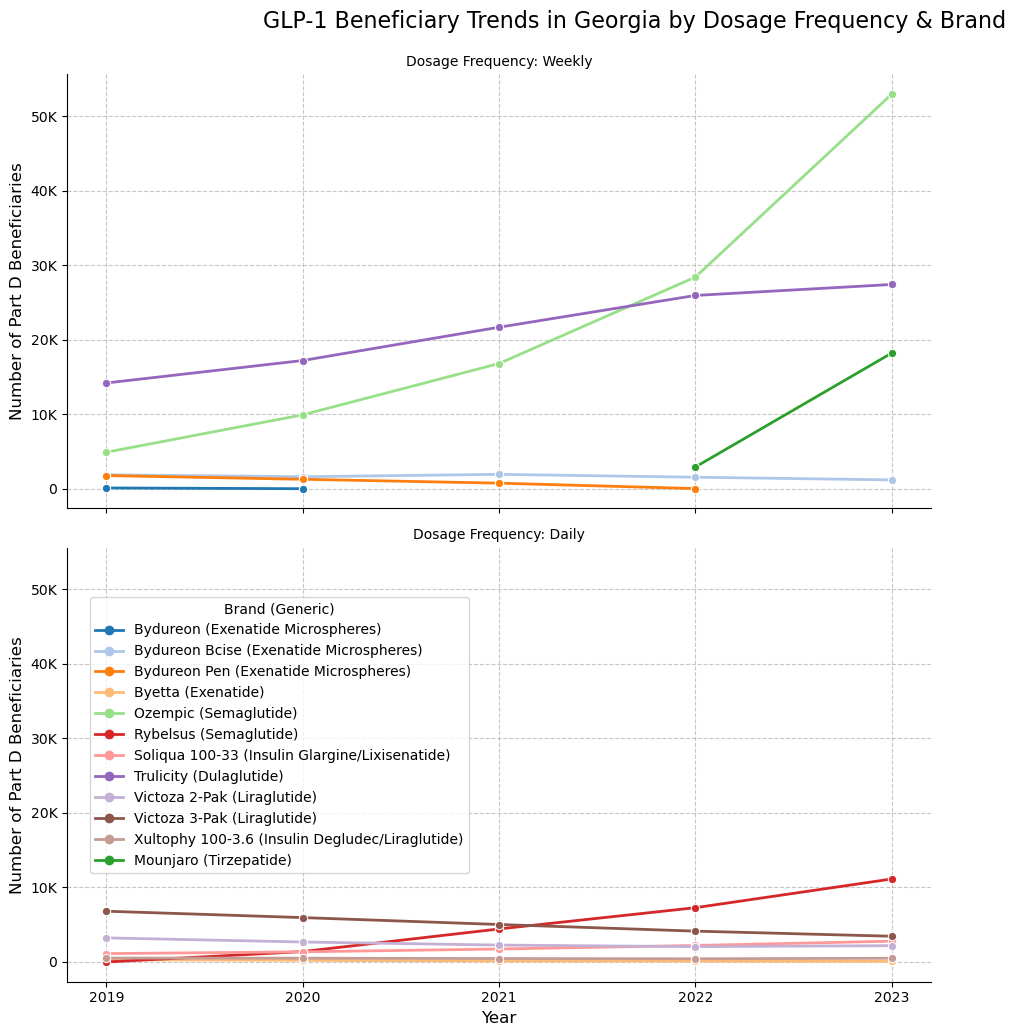

In [42]:
# Aggregate by Year, Brand Name, Generic Name, Dosage Frequency
georgia_brand_agg = georgia_data.groupby(
    ['Year', 'Brnd_Name', 'Gnrc_Name', 'Dosage_Frequency'],dropna=False)[['Tot_Benes', 'Tot_Drug_Cst']].sum().reset_index()

print(georgia_brand_agg.head(10))
georgia_brand_agg['Display_Label'] = georgia_brand_agg['Brnd_Name'] + ' (' + georgia_brand_agg['Gnrc_Name'] + ')'
unique_display_labels = sorted(georgia_brand_agg['Display_Label'].unique())
palette_brand = sns.color_palette('tab20', n_colors=len(unique_display_labels))
color_map_brand = dict(zip(unique_display_labels, palette_brand))

g = sns.relplot(
    data=georgia_brand_agg,
    x='Year',
    y='Tot_Benes',
    hue='Display_Label',
    row='Dosage_Frequency',
    kind='line',
    marker='o',
    linewidth=2,
    palette=color_map_brand,
    height=5,
    aspect=2
)

g.fig.suptitle('GLP-1 Beneficiary Trends in Georgia by Dosage Frequency & Brand', y=1.03, fontsize=16)
g.set_axis_labels("Year", "Number of Part D Beneficiaries", fontsize=12) # X, Y axis lables
g.set_titles("Dosage Frequency: {row_name}", fontsize=20) # title for each plot
g.set(xticks=georgia_brand_agg['Year'].unique())

# Y-axis formatting and applying grid
def simple_formatter(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(simple_formatter))
    ax.grid(True, linestyle='--', alpha=0.7)

# Brand(Generic) Legend positioning
sns.move_legend(g, "upper left", bbox_to_anchor=(0.1, 0.45), title='Brand (Generic)', frameon=True)
# Display plots
plt.show()


## 6. Conclusion
### 6.1. Summary
- <span style="font-size: 16px;">The number of Medicare Part D beneficiaries utilizing GLP-1 agonists has shown <b>a significant upward trend</b> year over year. This class of medications is primarily indicated for the treatment of type 2 diabetes and, more recently, for obesity management. Most medications within this class are administered via subcutaneous.</span>
- <span style="font-size: 16px;">Particularly noteworthy growth trends are observed for <b>Trulicity (Dulaglutide), Ozempic (Semaglutide), and Mounjaro (Tirzepatide)</b> since their respective introductions to the US market.</span>
- <span style="font-size: 16px;"><b>A key differentiator</b> identified among these rapidly growing GLP-1 agonists and others relates to <b>dosage frequency</b>. Analysis suggests a potential preference among Medicare beneficiaries for the convenience of once-weekly dosing regimens over once-daily options. This is supported by the pronounced growth trajectories observed for the once-weekly agents Trulicity, Ozempic, and Mounjaro compared to the daily administered agents analyzed.</span>
- <span style="font-size: 16px;"><b>An exception to this trend among weekly agents is Exenatide extended-release (Bydureon)</b>. While also administered weekly, its beneficiary count has not seen comparable growth. <b>Published clinical research often indicates lower comparative efficacy for Exenatide in A1C reduction and weight loss</b> compared to newer GLP-1 receptor agonists like Semaglutide, Dulaglutide, and Tirzepatide. This could be a contributing factor to the lower utilization of Exenatide, <b>potentially suggesting prescriber awareness of newer alternatives</b> within the same therapeutic class offering greater efficacy.</span>

### 6.2. Limitations
This data analysis has the following limitations:

1. <b>Data Source and Time Period</b>: The analysis is based solely on publicly available U.S. Medicare Part D prescriber data (by Geography and Drug). The data used covers the period from 2014 to 2023. As of the time of analysis (April 2025), public data for 2024 was not yet available and therefore is not included. Consequently, the most recent trends may not be reflected.
2. <b>Target Population</b>: The findings represent trends specific to the Medicare Part D beneficiary population. They may not be directly generalizable to trends among commercially insured patients or the entire U.S. population utilizing GLP-1 agonists, especially considering potential differences in usage patterns (e.g., for weight loss) which might be more prominent in the market.
3. <b>Data Granularity</b>: The data utilized is aggregated at the state or national level by drug. It does not contain individual patient-level information (e.g., comorbidities, specific indications like diabetes vs. weight loss, adherence, reasons for medication switching) or detailed individual prescriber data. This restricts the ability to perform in-depth analyses based on patient characteristics or individual prescriber behaviors.
4. <b>Correlation vs. Causation:</b> This analysis primarily identifies correlations and trends over time, such as shifts in market share or relationships with cost. While observations like the growing preference for once-weekly formulations were noted, this analysis cannot definitively establish causal relationships (e.g., it cannot prove convenience caused the preference without further study).
5. <b>External Factors:</b> Various external factors that could influence prescribing trends during the analysis period (e.g., changes in specific drug marketing efforts, formulary changes beyond basic cost-sharing tiers (e.g. copay), drug shortages, updates to clinical guidelines) were not directly accounted for in this analysis.
6. <b>Application of Domain Knowledge:</b> Dosage frequency information was added based on pharmacological expertise and standard clinical practice. This mapping may not capture variations in individual patient dosing regimens or potential off-label use present in the raw prescribing events.
